## State

In [1]:
from typing_extensions import TypedDict 

class State(TypedDict):
    graph_state : str

## Nodes

In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state" : state["graph_state"] + " Welcome"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state" : state["graph_state"] + " to the World!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state" : state["graph_state"] + " to the Hyderabad!"}

## Edges

In [3]:
import random 
from typing import Literal 

def decide_node(state) -> Literal["node_2", "node_3"]:
    user_input = state["graph_state"]
    if random.random() < 0.5:
        return "node_2"

    return "node_3"

## Graph Construction

In [7]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_conditional_edges(
    "node_1",
    decide_node
)
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)

graph = graph_builder.compile()

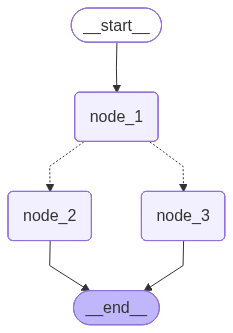

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"graph_state" : "Hello"})

---Node 1---
---Node 3---


{'graph_state': 'Hello Welcome to the Hyderabad!'}

In [10]:
graph.invoke({"graph_state" : "Hello"})

---Node 1---
---Node 3---


{'graph_state': 'Hello Welcome to the Hyderabad!'}

In [11]:
graph.invoke({"graph_state" : "Hello"})

---Node 1---
---Node 2---


{'graph_state': 'Hello Welcome to the World!'}

In [13]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

## Tools

In [14]:
def multiply(a: int, b: int) -> int:
    """Multiple a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b 

llm_with_tools = llm.bind_tools([multiply])

In [ ]:
from langchain_core.messages import HumanMessage

no_tool_call = llm_with_tools.invoke(
    [HumanMessage(content="Hi")]
)

In [16]:
no_tool_call.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [18]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content=f"What is 2 multiplied by 3", name="Miguel")]
)
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_c869sqz4cpPvJ23bXPAJW8tQ)
 Call ID: call_c869sqz4cpPvJ23bXPAJW8tQ
  Args:
    a: 2
    b: 3


In [19]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c869sqz4cpPvJ23bXPAJW8tQ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 63, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CYnkU18H0PALGTpu8GQIXb5nvDee9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fa1633c9-5601-44f0-914c-68b283a4e487-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_c869sqz4cpPvJ23bXPAJW8tQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 63, 'output_tokens': 17, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_rea

In [20]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_c869sqz4cpPvJ23bXPAJW8tQ',
  'type': 'tool_call'}]

## React Agent

In [21]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [22]:
llm_with_tools = llm.bind_tools(tools)

In [44]:
from langgraph.graph import MessagesState 
from langchain_core.messages import HumanMessage 
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

sys_prompt = "You are a helpful assistant"

def assistant(state : MessagesState):
    response = llm_with_tools.invoke([sys_prompt] + state["messages"])
    return {
        "messages" : [response]
    }

In [45]:
from langgraph.graph import START, StateGraph, END 
from langgraph.prebuilt import tools_condition, ToolNode 

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "assistant")
graph_builder.add_conditional_edges(
    "assistant",
    tools_condition
)
graph_builder.add_edge("tools", "assistant")

react_agent = graph_builder.compile()


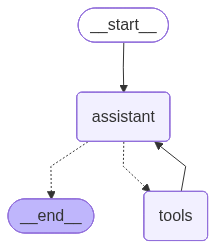

In [46]:
from IPython.display import Image, display
display(Image(react_agent.get_graph(xray=True).draw_mermaid_png()))

In [47]:
messages = [HumanMessage(content="Add 10 and 5. Multiply the output by 2. Divide the output by 5")]
messages = react_agent.invoke({"messages": messages})
for m in messages['messages']:
    print(m.pretty_print())

================================ Human Message =================================

Add 10 and 5. Multiply the output by 2. Divide the output by 5
None
================================== Ai Message ==================================
Tool Calls:
  add (call_rIhl364sA1XJwqcjnDlGYn0A)
 Call ID: call_rIhl364sA1XJwqcjnDlGYn0A
  Args:
    a: 10
    b: 5
None
================================= Tool Message =================================
Name: add

15
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JLbyH90c5MBXykv3UjhNIpUA)
 Call ID: call_JLbyH90c5MBXykv3UjhNIpUA
  Args:
    a: 15
    b: 2
None
================================= Tool Message =================================
Name: multiply

30
None
================================== Ai Message ==================================
Tool Calls:
  divide (call_ex2FmCJSJcY8pFl2FR0EpS6T)
 Call ID: call_ex2FmCJSJcY8pFl2FR0EpS6T
  Args:
    a: 30
    b: 5
None
============================